In [1]:
# import packages for visualization
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [3]:
from map_plan import *

In [4]:
sample_map = create_sample_map()
obstacle_map = sample_map[:,:,0]
goal_map = sample_map[:,:,1]
current_pos_map = sample_map[:,:,2]

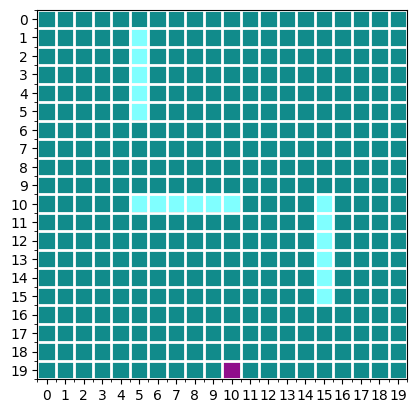

In [5]:
ax = plot_soft_position(obstacle_map, cmap='hot', alpha=0.9)
ax = plot_soft_position(goal_map, cmap='cool', alpha=0.5, ax=ax)

(tensor(0.), tensor(0.))
(tensor(0.2921), tensor(0.2921))


/Users/kyunghyuncho/anaconda3/lib/python3.9/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /private/var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_1aidzjezue/croot/pytorch_1687856425340/work/aten/src/ATen/native/TensorShape.cpp:3484.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


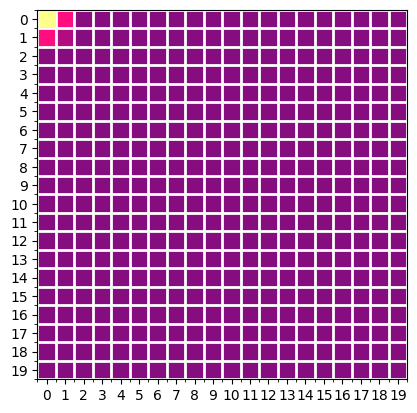

In [6]:
current_coord = get_hard_position(current_pos_map)
print(current_coord)
current_soft_map = get_soft_position(current_coord[0], current_coord[1])
current_soft_coord = get_hard_position(current_soft_map)
print(current_soft_coord)

ax = plot_soft_position(current_pos_map, cmap='spring', alpha=0.9)
ax = plot_soft_position(current_soft_map, cmap='hot', alpha=0.5, ax=ax)

(tensor(8.0000), tensor(8.))


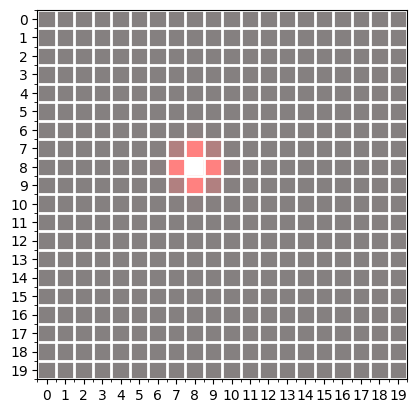

In [7]:
current_soft_map = get_soft_position(8, 8)
current_soft_coord = get_hard_position(current_soft_map)
print(current_soft_coord)

ax = plot_soft_position(current_soft_map, cmap='hot', alpha=0.5)

In [16]:
# perform gradient descent on the trajectory
# the beginning is the current position
trajectory_length = 10
trajectory = torch.zeros(trajectory_length, 2)
trajectory[0] = torch.tensor(get_hard_position(current_pos_map, argmax=True))

# randomly initialize the rest of the steps of `trajectory`
for i in range(1, trajectory_length):
    trajectory[i] = torch.tensor([np.random.randint(0, obstacle_map.shape[0]), 
                                  np.random.randint(0, obstacle_map.shape[0])])

n_steps = 5000
learning_rate = 0.1

for step in range(n_steps):
    trajectory = trajectory.clone().detach()
    trajectory.requires_grad = True
    trajectory.grad = None

    score = score_trajectory(trajectory, obstacle_map, goal_map, current_pos_map,
                             distance_coeff=10.0, 
                             collision_coeff=100.0, 
                             smoothness_coeff=10., 
                             distance_from_current_coeff=10.0)
    score.backward()

    trajectory = trajectory - learning_rate * trajectory.grad

    if step % 100 == 0:
        print(f'Step {step+1} Score {score.item()}')

trajectory = trajectory.detach()

Step 1 Score 792.871826171875
Step 101 Score 172.4718017578125
Step 201 Score 163.53305053710938
Step 301 Score 171.4126739501953
Step 401 Score 88.84025573730469
Step 501 Score 93.9481201171875
Step 601 Score 85.31290435791016
Step 701 Score 93.27061462402344
Step 801 Score 86.76063537597656
Step 901 Score 83.77301025390625
Step 1001 Score 93.76871490478516
Step 1101 Score 86.61151885986328
Step 1201 Score 84.26714324951172
Step 1301 Score 93.42337799072266
Step 1401 Score 86.18293762207031
Step 1501 Score 85.32842254638672
Step 1601 Score 92.76036834716797
Step 1701 Score 85.40153503417969
Step 1801 Score 87.16371154785156
Step 1901 Score 91.67842102050781
Step 2001 Score 84.20977020263672
Step 2101 Score 88.42137145996094
Step 2201 Score 88.40312194824219
Step 2301 Score 88.40348052978516
Step 2401 Score 88.40352630615234
Step 2501 Score 88.40351104736328
Step 2601 Score 88.40352630615234
Step 2701 Score 88.40351867675781
Step 2801 Score 88.40352630615234
Step 2901 Score 88.40351867

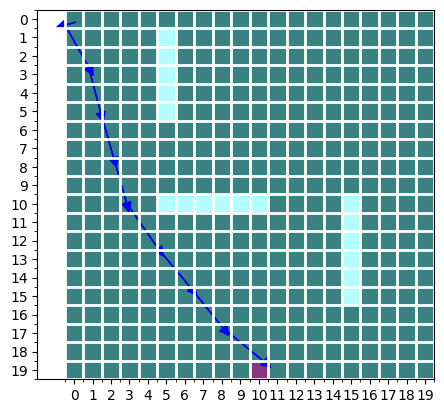

In [17]:
# plot the trajectory
ax = plot_soft_position(obstacle_map, cmap='hot', alpha=0.7)
ax = plot_soft_position(goal_map, cmap='cool', alpha=0.3, ax=ax)
for i in range(trajectory_length):
    if i > 0:
        # draw an arrow from the previous point to the current poin in the trajectory.
        ax.arrow(trajectory[i-1, 1], trajectory[i-1, 0], 
                 trajectory[i, 1]-trajectory[i-1, 1], 
                 trajectory[i, 0]-trajectory[i-1, 0], 
                 head_width=0.5, head_length=0.5, fc='b', ec='b')